# Problem

Sebuah perusahaan ojek online yang menyediakan jasa pengantaran makanan ingin mengoptimalkan pembagian diskon sesuai dengan segmen customer. Customer akan dibagi menjadi 3 klaster berdasarkan nominal pemesanan, frekuensi pemesanan, dan selisih hari order.

# Variabel yang Tersedia

**1. order_id** : unique identifier order\
**2. voucher_amount** : potongan harga makanan\
**3. date_time** : waktu order\
**4. eta_seconds** : lama pengantaran\
**5. food_price** : harga makanan\
**6. cust_id** : unique identifier customer\
**7. rating** : rating kepuasan customer\
**8. delivery_fee** : ongkos kirim\
**9. resto_id** : unique identifier restoran\
**10. status** : status order\
**11. random_id** : unique identifier random

# Import Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
import warnings
warnings.filterwarnings('ignore')

# Data For Clustering

In [2]:
data = pd.read_csv( "food_delivery_datasets.csv" )
data

,order_id,voucher_amount,date_time,eta_seconds,food_price,cust_id,rating,delivery_fee,resto_id,status,random_id
0,FOOD-10455,0,2018-08-12T20:35:08.001006,1800,18900,1089034,5.0,4000,742638033,Completed,0.511149
1,FOOD-10985,0,2018-09-23T17:44:12.243273,2173,149000,180146,5.0,11000,742767245,Completed,0.832936
2,FOOD-10911,0,2018-09-19T18:08:09.387991,1418,43800,366528,NaN,9000,742618303,Completed,0.828026
3,FOOD-10932,0,2018-09-21T01:24:35.272499,1903,39900,511038,5.0,14000,742541172,Completed,0.239377
4,FOOD-10961,0,2018-09-22T17:57:45.523161,1716,77700,1220358,NaN,4000,742604875,Completed,0.995587
...,...,...,...,...,...,...,...,...,...,...,...
1071,FOOD-10921,0,2018-09-20T15:01:52.152828,900,103200,1296335,5.0,4000,742742150,Completed,0.248328
1072,FOOD-10265,5000,2018-07-26T14:43:23.655294,1579,145700,1135466,5.0,7000,742566851,Completed,0.268251
1073,FOOD-10534,0,2018-08-21T20:10:59.283185,2606,177200,1383625,NaN,15000,742571888,Completed,0.132528
1074,FOOD-10158,0,2018-07-16T14:42:23.214427,2428,49300,1094787,5.0,9000,742725064,Completed,0.167946


# Data Preparation

hapus variabel yang tidak diperlukan dalam clustering, seperti random_id, status, resto_id, dan rating

In [3]:
data.drop(['random_id', 'status', 'resto_id', 'rating'], axis=1, inplace=True)
data

,order_id,voucher_amount,date_time,eta_seconds,food_price,cust_id,delivery_fee
0,FOOD-10455,0,2018-08-12T20:35:08.001006,1800,18900,1089034,4000
1,FOOD-10985,0,2018-09-23T17:44:12.243273,2173,149000,180146,11000
2,FOOD-10911,0,2018-09-19T18:08:09.387991,1418,43800,366528,9000
3,FOOD-10932,0,2018-09-21T01:24:35.272499,1903,39900,511038,14000
4,FOOD-10961,0,2018-09-22T17:57:45.523161,1716,77700,1220358,4000
...,...,...,...,...,...,...,...
1071,FOOD-10921,0,2018-09-20T15:01:52.152828,900,103200,1296335,4000
1072,FOOD-10265,5000,2018-07-26T14:43:23.655294,1579,145700,1135466,7000
1073,FOOD-10534,0,2018-08-21T20:10:59.283185,2606,177200,1383625,15000
1074,FOOD-10158,0,2018-07-16T14:42:23.214427,2428,49300,1094787,9000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        1076 non-null   object
 1   voucher_amount  1076 non-null   int64 
 2   date_time       1076 non-null   object
 3   eta_seconds     1076 non-null   int64 
 4   food_price      1076 non-null   int64 
 5   cust_id         1076 non-null   int64 
 6   delivery_fee    1076 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 59.0+ KB


In [5]:
data["cust_id"]= data["cust_id"].astype(str)

In [6]:
# New Attribute : Monetary

data['Amount'] = data['delivery_fee']+data['food_price']
rfm_m = data.groupby('cust_id')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,cust_id,Amount
0,1008214,283900
1,1008998,248300
2,1010922,321000
3,1011942,173600
4,1012995,387100


In [7]:
# New Attribute : Frequency

rfm_f = data.groupby('cust_id')['order_id'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['cust_id', 'Frequency']
rfm_f.head()

,cust_id,Frequency
0,1008214,3
1,1008998,4
2,1010922,6
3,1011942,3
4,1012995,4


In [8]:
rfm = pd.merge(rfm_m, rfm_f, on='cust_id', how='inner')
rfm.head()

,cust_id,Amount,Frequency
0,1008214,283900,3
1,1008998,248300,4
2,1010922,321000,6
3,1011942,173600,3
4,1012995,387100,4


In [9]:
# New Attribute : Recency

# Convert to datetime to proper datatype

data['date_time'] = pd.to_datetime(data['date_time'],format='%Y-%m-%dT%H:%M:%S')

# Compute the maximum date to know the last transaction date

max_date = max(data['date_time'])
max_date

# Compute the difference between max date and transaction date

data['Diff'] = max_date - data['date_time']
data.head()

# Compute last transaction date to get the recency of customers

rfm_p = data.groupby('cust_id')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,cust_id,Diff
0,1008214,4 days 04:29:33.372369
1,1008998,3 days 23:03:31.423129
2,1010922,4 days 03:40:23.387540
3,1011942,58 days 01:33:09.580972
4,1012995,4 days 07:54:40.651388


In [10]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_pp  = rfm_p.sort_values(by='Diff')
print(rfm_pp)

     cust_id  Diff
120    82880     0
129   884440     0
128   866805     0
127   861950     0
119    82690     0
..       ...   ...
101   614144    78
137   979027    78
95    580514    84
50   1470304    89
49    146294    91

[138 rows x 2 columns]


In [11]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm,rfm_p, on='cust_id', how='inner')
rfm.columns = ['cust_id', 'Amount', 'Frequency', 'Recency']
rfm.head()

,cust_id,Amount,Frequency,Recency
0,1008214,283900,3,4
1,1008998,248300,4,3
2,1010922,321000,6,4
3,1011942,173600,3,58
4,1012995,387100,4,4


Text(0.5, 0, 'Attributes')

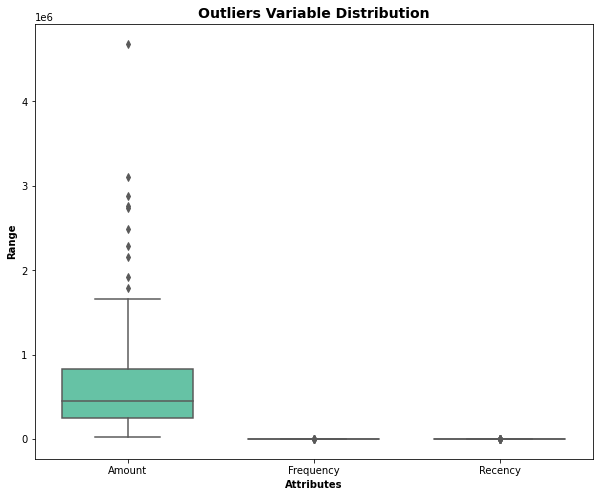

In [12]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [13]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [14]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(138, 3)

In [15]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.560837,-0.723052,-0.545634
1,-0.611161,-0.572325,-0.597243
2,-0.508393,-0.270872,-0.545634
3,-0.716757,-0.723052,2.241251
4,-0.414954,-0.572325,-0.545634


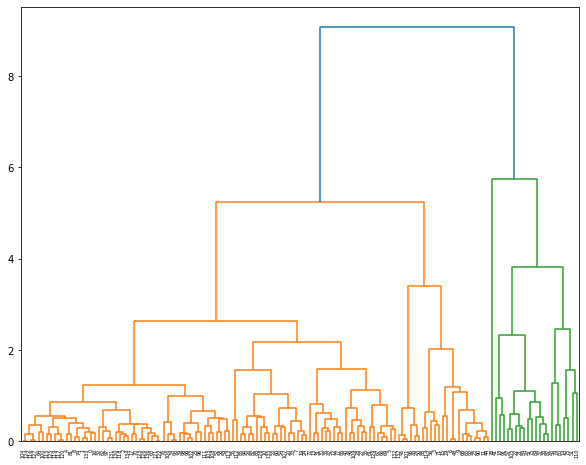

In [16]:
#building model
#Hierarchical Clustering
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [17]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [18]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,cust_id,Amount,Frequency,Recency,Cluster_Labels
0,1008214,283900,3,4,0
1,1008998,248300,4,3,0
2,1010922,321000,6,4,0
3,1011942,173600,3,58,0
4,1012995,387100,4,4,0


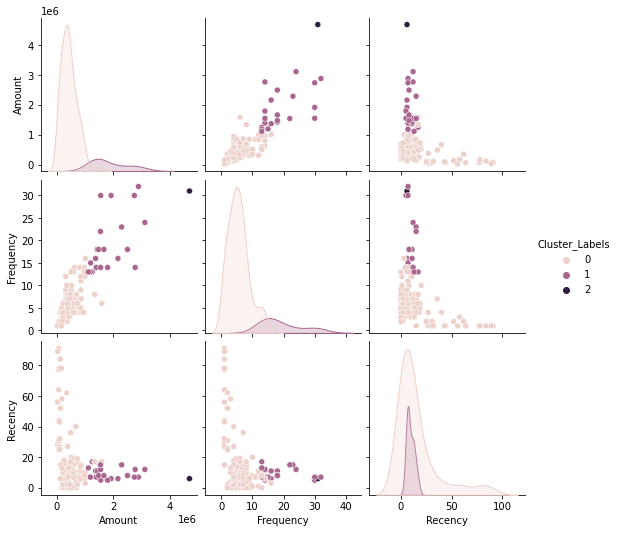

In [19]:
sns.pairplot(rfm, hue='Cluster_Labels')

# Hasil :

1. Customer dengan klaster 2 merupakan klaster tertinggi, yaitu customer dengan frekuensi pemesanan paling sering, nominal pembelian paling tinggi, serta selisih hari order tidak lama.

2. Customer dengan klaster 1 merupakan klaster menengah, yaitu customer dengan frekuensi pemesanan cukup sering, nominal pembelian menengah, serta selisih hari order cukup lama.

3. Customer dengan klaster 0 merupakan klaster terendah, yaitu customer dengan frekuensi pemesanan jarang, nominal pembelian paling sedikit, serta selisih hari order sangat lama.

Dengan hasil yang diperoleh, perusahaan tersebut dapat memberikan voucher potongan harga hanya kepada customer klaster 2, dimana customer tersebut yang paling berpotensi untuk repeat order dan memberikan banyak keuntungan bagi perusahaan.